# Information Globale

## Importation

In [108]:
#Générique Importation
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

#Générique Importation
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

#
from vacances_scolaires_france import SchoolHolidayDates

#Sclaing
from sklearn.preprocessing import RobustScaler

#Machine Learning
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from lineartree           import LinearBoostRegressor
from sklearn.linear_model import LinearRegression

#Vizualisation
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})


#Preprocessing Interne
from analyse.preproc_RTE import preprocessing_RTE_encours, preproc_temperature_ENEDIS, preproc_tempo
from analyse.preproc_RTE import add_schoolholidays, add_weekday, add_public_holidays


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
# Data Import
## Puissance
EnCours_Consolide = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-Consolide.csv",delimiter=";")
EnCours_Temps_R = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-TR.csv",delimiter=";")
Temp_Dep = pd.read_csv("data/temperature-quotidienne-departementale.csv",delimiter=";")
Temp_Nationale = pd.read_csv("data/donnees-de-temperature-et-de-pseudo-rayonnement.csv",delimiter=";")

Tempo_RTE_2122 = pd.read_csv("data/puissance/eCO2mix_RTE_tempo_2021-2022.csv",delimiter=";")
Tempo_RTE_2223 = pd.read_csv("data/puissance/eCO2mix_RTE_tempo_2022-2023.csv",delimiter=";")
Tempo_RTE_2324 = pd.read_csv("data/puissance/eCO2mix_RTE_tempo_2023-2024.csv",delimiter=";")

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3326194778.py:3: DtypeWarning: Columns (36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  EnCours_Consolide = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-Consolide.csv",delimiter=";")
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3326194778.py:4: DtypeWarning: Columns (5,26,27,30,31,33,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  EnCours_Temps_R = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-TR.csv",delimiter=";")


## Explication Choix TR

J'ai souhaité prendre seumlement le TR pour deux raisons :
- on souhaite prédire pour le lendemain donc plus logique dans la démarceh d'utilisé les valeurs de la veille (ou de S-2 dans le cas de TILT)
- minimiser l'impact COVID, ça ne sert à rien de revenir trop en arrière à cause de l'effet COVID qui va influencer.

- TR : Temps Réel, donc mis à jour avec prévision et modléisation de ce que l'on peut récupérer
- Consolidé : Données consolidé avec échnages des différentes antennes.

## Train Test Split

In [136]:
n = 70 #Prédiction des 70 valeurs de fin, afin de récupérer la veille à 12h // conso_final_TR_merged.shape[0]
# A valider si modif de l'excel intial

train = df_final.iloc[:-n]
test = df_final.iloc[-n:]

X_train = train.drop(columns='Consommation')
y_train = train.Consommation

X_test = test.drop(columns='Consommation')
y_test = test.Consommation

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(28488, 89) (70, 89) (28488,) (70,)


## Scaling

In [137]:
# Step 0 - Instanciate Robust Scale
rb_scaler = RobustScaler()

# Step 1- Fit the scaler
rb_scaler.fit(X_train)

# 2-Scale/Transform
X_train_scaled = rb_scaler.transform(X_train)
X_test_scaled = rb_scaler.transform(X_test)

#Possibilité de faire une Pipeline au besoin si
# l'on souhaite appliquer des scaleurs précis

In [138]:
train

,Consommation,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,sin_month,cos_month,sin_day,cos_day,sin_hour,...,Temp_shift18,Temp_shift19,Temp_shift20,Temp_shift21,Temp_shift22,Temp_shift23,Temp_shift24,Type de jour TEMPO_BLANC,Type de jour TEMPO_BLEU,Type de jour TEMPO_ROUGE
48,45208.0,0,0,16.9,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.000000,...,50002.0,50251.0,51061.0,51434.0,52071.0,52745.0,52351.0,0.0,1.0,0.0
49,42420.0,0,0,16.9,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.000000,...,49041.0,50002.0,50251.0,51061.0,51434.0,52071.0,52745.0,0.0,1.0,0.0
50,40356.0,0,0,16.8,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.258819,...,48644.0,49041.0,50002.0,50251.0,51061.0,51434.0,52071.0,0.0,1.0,0.0
51,40299.0,0,0,16.8,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.258819,...,48182.0,48644.0,49041.0,50002.0,50251.0,51061.0,51434.0,0.0,1.0,0.0
52,39840.0,0,0,16.8,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.500000,...,47927.0,48182.0,48644.0,49041.0,50002.0,50251.0,51061.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28531,80448.0,0,0,1.4,2024,5.000000e-01,0.866025,-0.101168,-0.994869,0.707107,...,67812.0,69224.0,69631.0,70366.0,69703.0,68989.0,69863.0,0.0,0.0,1.0
28532,80178.0,0,0,1.7,2024,5.000000e-01,0.866025,-0.101168,-0.994869,0.500000,...,66231.0,67812.0,69224.0,69631.0,70366.0,69703.0,68989.0,0.0,0.0,1.0
28533,79772.0,0,0,2.0,2024,5.000000e-01,0.866025,-0.101168,-0.994869,0.500000,...,66752.0,66231.0,67812.0,69224.0,69631.0,70366.0,69703.0,0.0,0.0,1.0
28534,78740.0,0,0,2.4,2024,5.000000e-01,0.866025,-0.101168,-0.994869,0.258819,...,66658.0,66752.0,66231.0,67812.0,69224.0,69631.0,70366.0,0.0,0.0,1.0


## Modélisation 1 : HistGradientBoostingRegressor

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/1163403234.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = regressor.predict(X_test_scaled)


<AxesSubplot:>

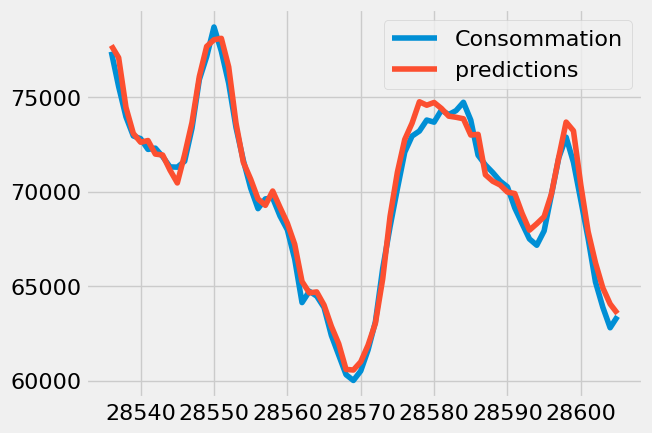

In [139]:
#0.6sec
regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
regressor.fit(X_train_scaled, y_train)

test["predictions"] = regressor.predict(X_test_scaled)
test[['Consommation','predictions']].plot()

## Essayer d'ajouter les bonnes valeurs des heures pour meilleures compréhension

In [140]:
test

,Consommation,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,sin_month,cos_month,sin_day,cos_day,sin_hour,...,Temp_shift19,Temp_shift20,Temp_shift21,Temp_shift22,Temp_shift23,Temp_shift24,Type de jour TEMPO_BLANC,Type de jour TEMPO_BLEU,Type de jour TEMPO_ROUGE,predictions
28536,77402.0,0,0,3.1,2024,0.5,0.866025,-0.101168,-0.994869,1.224647e-16,...,66594.0,66658.0,66752.0,66231.0,67812.0,69224.0,0.0,0.0,1.0,77734.008389
28537,75562.0,0,0,3.2,2024,0.5,0.866025,-0.101168,-0.994869,1.224647e-16,...,65321.0,66594.0,66658.0,66752.0,66231.0,67812.0,0.0,0.0,1.0,77088.730347
28538,73957.0,0,0,3.2,2024,0.5,0.866025,-0.101168,-0.994869,-2.588190e-01,...,64898.0,65321.0,66594.0,66658.0,66752.0,66231.0,0.0,0.0,1.0,74453.853135
28539,72945.0,0,0,3.2,2024,0.5,0.866025,-0.101168,-0.994869,-2.588190e-01,...,64144.0,64898.0,65321.0,66594.0,66658.0,66752.0,0.0,0.0,1.0,73077.276322
28540,72800.0,0,0,3.3,2024,0.5,0.866025,-0.101168,-0.994869,-5.000000e-01,...,63994.0,64144.0,64898.0,65321.0,66594.0,66658.0,0.0,0.0,1.0,72611.017081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28601,67515.0,0,0,4.8,2024,0.5,0.866025,-0.299363,-0.954139,-8.660254e-01,...,74076.0,74310.0,73674.0,73785.0,73203.0,72939.0,1.0,0.0,0.0,67877.174734
28602,65217.0,0,0,4.8,2024,0.5,0.866025,-0.299363,-0.954139,-7.071068e-01,...,74286.0,74076.0,74310.0,73674.0,73785.0,73203.0,1.0,0.0,0.0,66230.173555
28603,63881.0,0,0,4.8,2024,0.5,0.866025,-0.299363,-0.954139,-7.071068e-01,...,74726.0,74286.0,74076.0,74310.0,73674.0,73785.0,1.0,0.0,0.0,64903.972376
28604,62791.0,0,0,4.8,2024,0.5,0.866025,-0.299363,-0.954139,-5.000000e-01,...,73783.0,74726.0,74286.0,74076.0,74310.0,73674.0,1.0,0.0,0.0,64050.767001


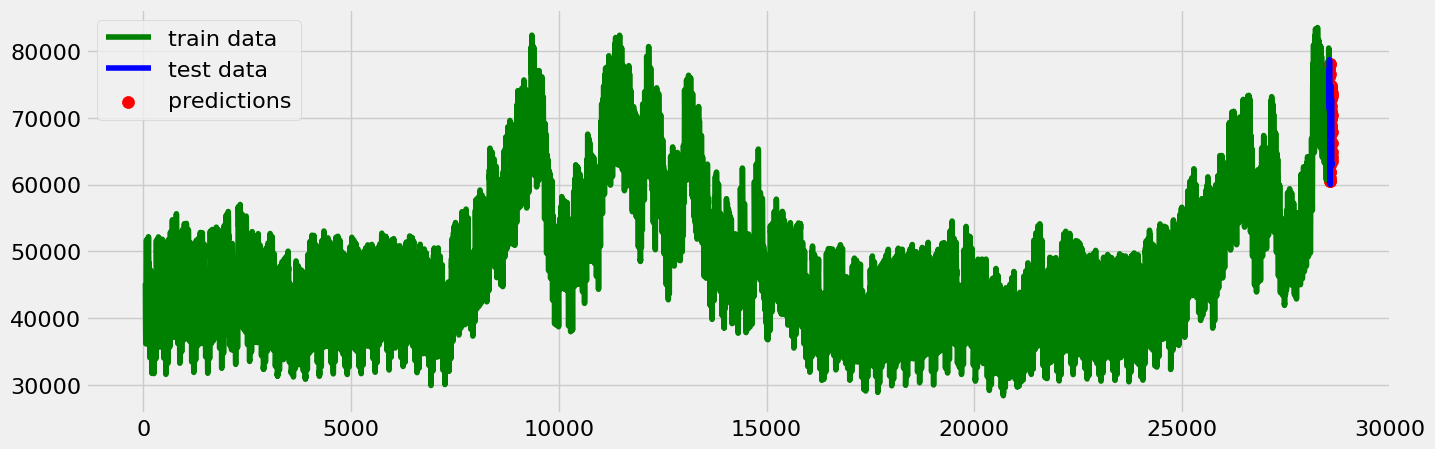

In [141]:
#Fig Globale
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train.index,train["Consommation"], label='train data', color="green")
ax.plot(test.index,test["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test.index, test["predictions"], label='predictions', color="red", s=75)
ax.legend(loc="upper left")

plt.show();

In [142]:
MAE_HGBR = mean_squared_error(test["Consommation"],test["predictions"])
MAPE_HGBR = mean_absolute_percentage_error(test["Consommation"],test["predictions"])

print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions"]))

MSE = 4.413e+05
MAPE = 0.007839


In [143]:
# Ante-Circular/Shift Values
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions"]))

MSE = 4.413e+05
MAPE = 0.007839


Conlusion :
    - Bon modèle dans notre cas car le maximum situé au milie de la courbe lui donne une "référence" de cette zone de consommation. Dans le cas ou il n irait pas aussi haut, la courbe est restreinte au maximum qu'il a rencontré dans le train (exemple ci dessous)

#### Exemple Train trop faible

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3319880666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_less_data"] = regressor.predict(X_test_scaled)


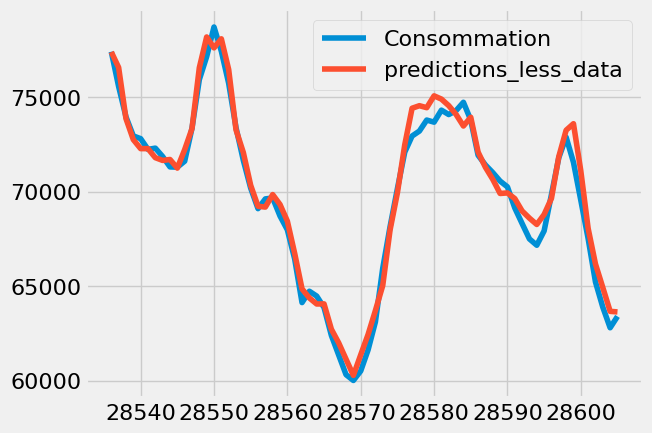

In [144]:
regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
regressor.fit(X_train_scaled[20000:], y_train[20000:])

test["predictions_less_data"] = regressor.predict(X_test_scaled)
test[['Consommation','predictions_less_data']].plot();

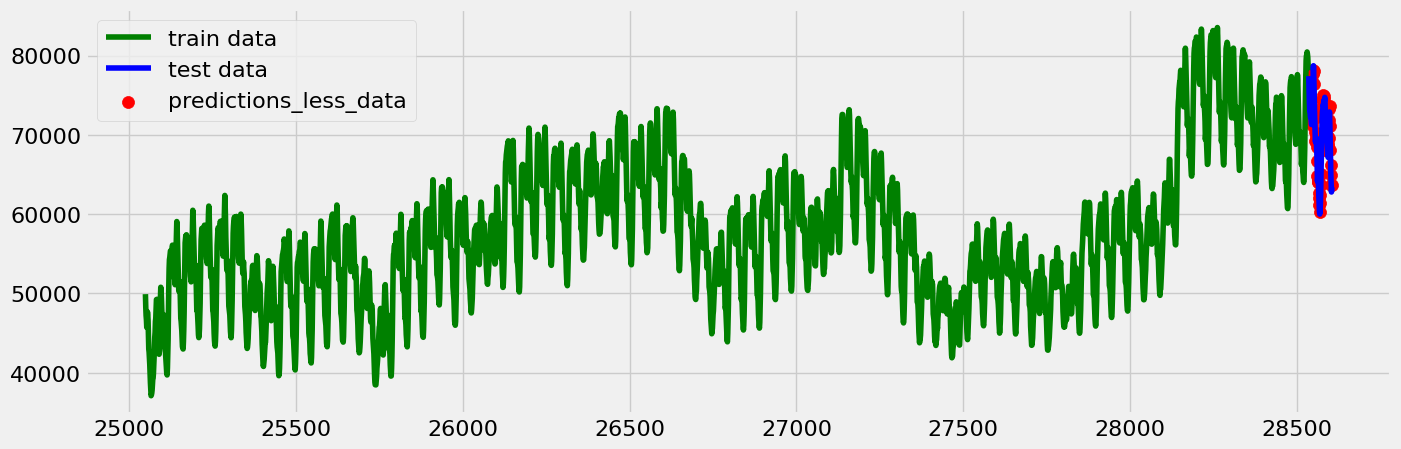

In [145]:
train_zoom = train[25000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_less_data"], label='predictions_less_data', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [146]:
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_less_data"]))
print('MSE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_less_data"]))

MSE = 4.973e+05
MSE = 0.00813


## Modélisation 2 : avec LinearBoostRegressor

https://github.com/cerlymarco/linear-tree

In [178]:
#5 min30sec
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 100,
                                 max_depth    = 3,
                                 random_state = 42)

regressor.fit(X_train_scaled, y_train)
test["predictions_Linear"] = regressor.predict(X_test_scaled)

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3535987623.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_Linear"] = regressor.predict(X_test_scaled)


In [148]:
df_final

,Consommation,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,sin_month,cos_month,sin_day,cos_day,sin_hour,...,Temp_shift18,Temp_shift19,Temp_shift20,Temp_shift21,Temp_shift22,Temp_shift23,Temp_shift24,Type de jour TEMPO_BLANC,Type de jour TEMPO_BLEU,Type de jour TEMPO_ROUGE
48,45208.0,0,0,16.9,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.000000,...,50002.0,50251.0,51061.0,51434.0,52071.0,52745.0,52351.0,0.0,1.0,0.0
49,42420.0,0,0,16.9,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.000000,...,49041.0,50002.0,50251.0,51061.0,51434.0,52071.0,52745.0,0.0,1.0,0.0
50,40356.0,0,0,16.8,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.258819,...,48644.0,49041.0,50002.0,50251.0,51061.0,51434.0,52071.0,0.0,1.0,0.0
51,40299.0,0,0,16.8,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.258819,...,48182.0,48644.0,49041.0,50002.0,50251.0,51061.0,51434.0,0.0,1.0,0.0
52,39840.0,0,0,16.8,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.500000,...,47927.0,48182.0,48644.0,49041.0,50002.0,50251.0,51061.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28601,67515.0,0,0,4.8,2024,5.000000e-01,0.866025,-0.299363,-0.954139,-0.866025,...,74286.0,74076.0,74310.0,73674.0,73785.0,73203.0,72939.0,1.0,0.0,0.0
28602,65217.0,0,0,4.8,2024,5.000000e-01,0.866025,-0.299363,-0.954139,-0.707107,...,74726.0,74286.0,74076.0,74310.0,73674.0,73785.0,73203.0,1.0,0.0,0.0
28603,63881.0,0,0,4.8,2024,5.000000e-01,0.866025,-0.299363,-0.954139,-0.707107,...,73783.0,74726.0,74286.0,74076.0,74310.0,73674.0,73785.0,1.0,0.0,0.0
28604,62791.0,0,0,4.8,2024,5.000000e-01,0.866025,-0.299363,-0.954139,-0.500000,...,71922.0,73783.0,74726.0,74286.0,74076.0,74310.0,73674.0,1.0,0.0,0.0


<AxesSubplot:>

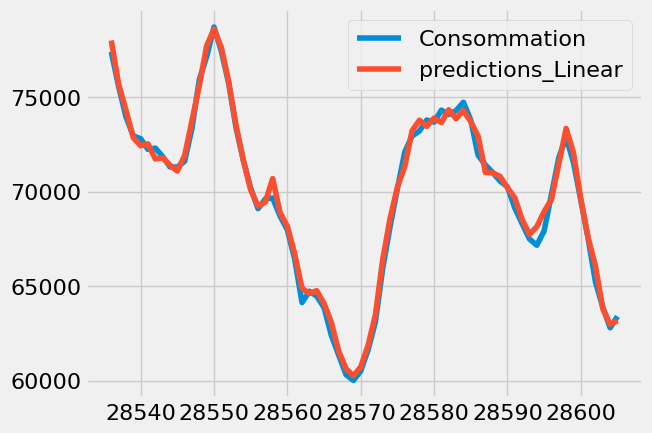

In [149]:
test[['Consommation','predictions_Linear']].plot()

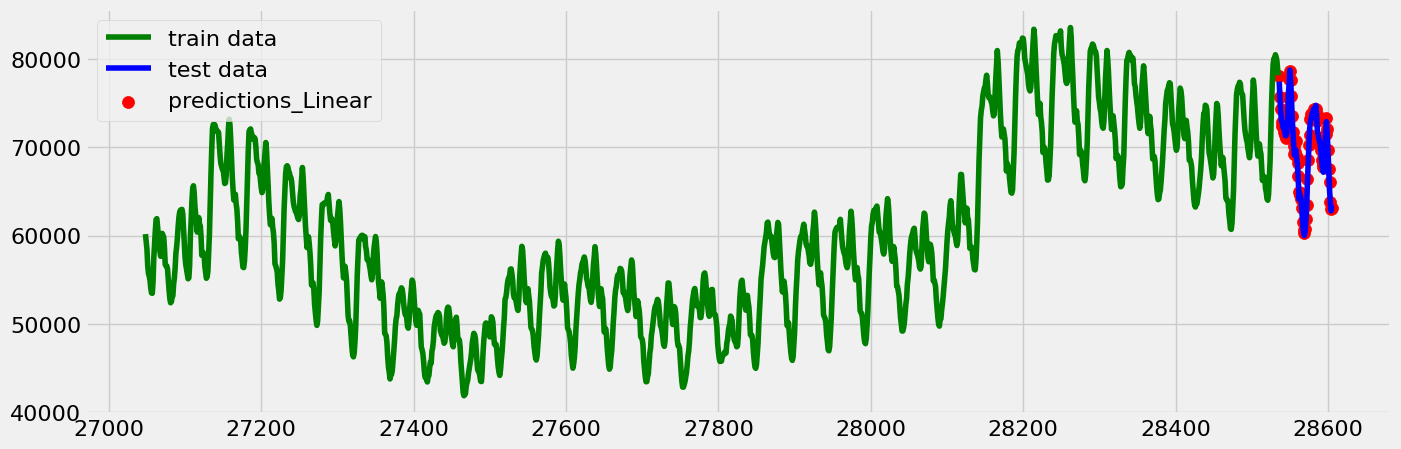

In [150]:
#Zoom sur l'ensemble
train_zoom = train[27000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_Linear"], label='predictions_Linear', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [179]:
MAE_LBR = mean_squared_error(test["Consommation"],test["predictions_Linear"])
MAPE_LBR = mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"])

print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"]))

MSE = 2.589e+05
MAPE = 0.005641


In [151]:
MAE_LBR = mean_squared_error(test["Consommation"],test["predictions_Linear"])
MAPE_LBR = mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"])

print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"]))

MSE = 1.758e+05
MAPE = 0.004805


In [152]:
# Ante-Circular/Shift Values
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"]))

MSE = 1.758e+05
MAPE = 0.004805


#### Exemple Train trop faible

In [153]:
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 300,
                                 max_depth    = 5,
                                 random_state = 42)

regressor.fit(X_train_scaled[20000:], y_train[20000:])
test["predictions_Linear_less_data"] = regressor.predict(X_test_scaled)


KeyboardInterrupt: 

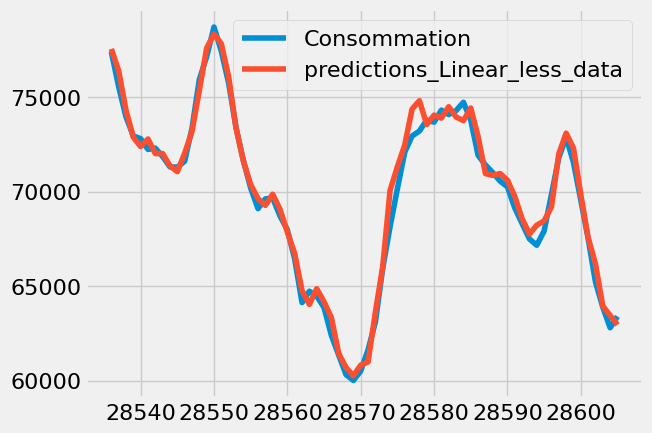

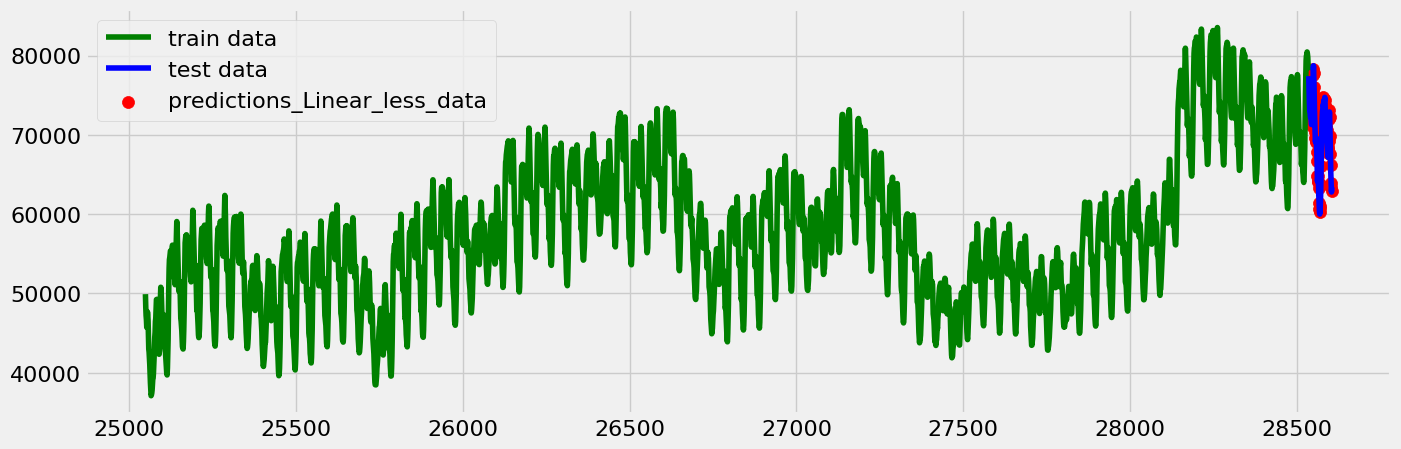

In [ ]:
test[['Consommation','predictions_Linear_less_data']].plot()

#Avec Zoom
train_zoom = train[25000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_Linear_less_data"], label='predictions_Linear_less_data', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [ ]:
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear_less_data"]))
print('MSE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear_less_data"]))

MSE = 3.467e+05
MSE = 0.006646


## Modélisation 3 : GradientBoostingRegressor

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/2145090659.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_GBR"] = regressor.predict(X_test_scaled)


<AxesSubplot:>

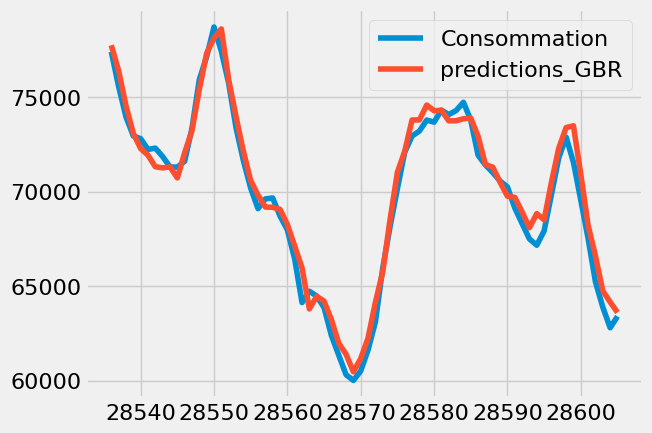

In [154]:
#0.6sec
regressor = GradientBoostingRegressor(n_estimators=200)
regressor.fit(X_train_scaled, y_train)

test["predictions_GBR"] = regressor.predict(X_test_scaled)
test[['Consommation','predictions_GBR']].plot()

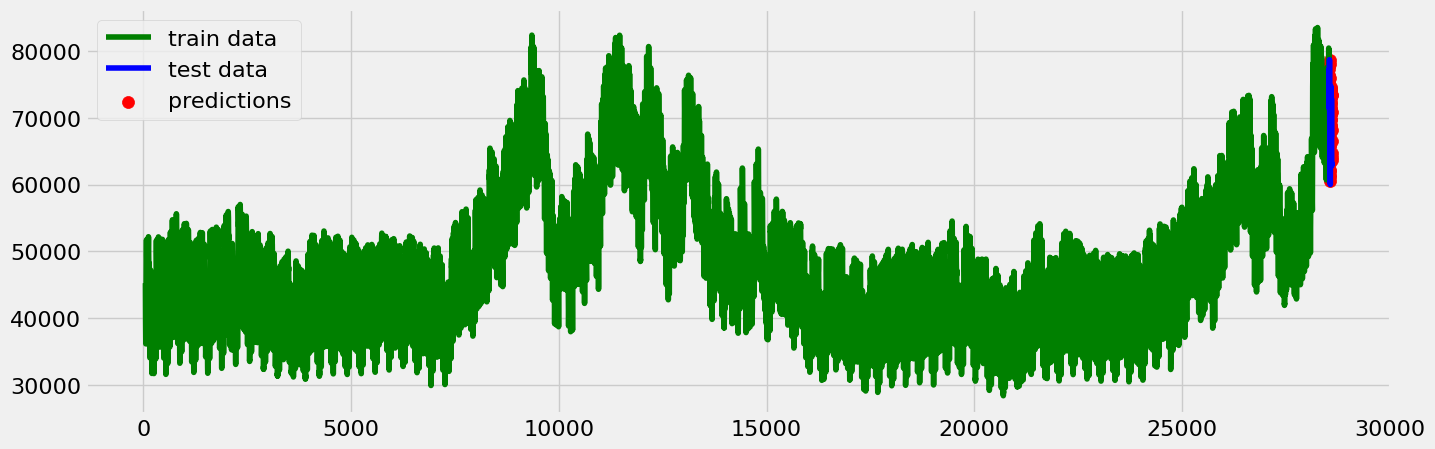

In [155]:
#Fig Globale
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train.index,train["Consommation"], label='train data', color="green")
ax.plot(test.index,test["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test.index, test["predictions_GBR"], label='predictions', color="red", s=75)
ax.legend(loc="upper left")

plt.show();

In [156]:
MAE_GBR = mean_squared_error(test["Consommation"],test["predictions_GBR"])
MAPE_GBR = mean_absolute_percentage_error(test["Consommation"],test["predictions_GBR"])


print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_GBR"]))
print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_GBR"]))

MSE = 5.408e+05
MAPE = 0.008839


## Modélisation 4 : XGBOOST

In [157]:
#import xgboost as xgb

In [158]:
# #0.6sec

# params = {
#     'objective': 'reg:squarederror',  # ou 'reg:squarederror' pour la régression
#     'max_depth': 3,
#     'learning_rate': 0.1,
#     'n_estimators': 100
# }

# dtrain = xgb.DMatrix(data=X_train_scaled, label=y_train)
# dtest = xgb.DMatrix(data=X_test_scaled, label=y_test)


# model = xgb.train(params=params, dtrain=dtrain)

# test["predictions"] = model.predict(dtest)
# test[['Consommation','predictions']].plot();

# ## Essayer d'ajouter les bonnes valeurs des heures pour meilleures compréhension

In [159]:
# #Fig Globale
# fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(train.index,train["Consommation"], label='train data', color="green")
# ax.plot(test.index,test["Consommation"], label='test data', color="blue")
# #ax.plot(test.index, test["predictions"],  label='predictions', color="red")
# ax.scatter(test.index, test["predictions"], label='predictions', color="red", s=75)
# ax.legend(loc="upper left")

# plt.show();

In [160]:
# print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions"]))
# print('MAPE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions"]))

## Modélisation 5 : Stats Forecast

# Conclusion

## Comparaison Résultat Singulier

In [170]:
MAE = [MAE_HGBR,MAE_LBR,MAE_GBR]
MAPE = 100*np.array([MAPE_HGBR,MAPE_LBR,MAPE_GBR])
mode = ['HGBR','LBR',"GBR"]
pd.DataFrame({"Modele":mode,"MAE":MAE,"MAPE (%)":MAPE}).sort_values('MAPE (%)')

,Modele,MAE,MAPE (%)
1,LBR,175816.000951,0.480535
0,HGBR,441346.119414,0.783896
2,GBR,540841.295510,0.883893


On remarque que le Modèle le plus intéressant est le LBT cependant, il est assez lent. Le HGBR est plus rapide de part sa constryction (Bin) mais reste moins précis. Le GBR, est le moins précis sur cet exemple de dataset. Il serait intéressant de comparer leur précision sur un DataSet plus imposant et pas seulement sur 1 journée.

## Comparaison Résultat

In [171]:
df_final

,Consommation,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,sin_month,cos_month,sin_day,cos_day,sin_hour,...,Temp_shift18,Temp_shift19,Temp_shift20,Temp_shift21,Temp_shift22,Temp_shift23,Temp_shift24,Type de jour TEMPO_BLANC,Type de jour TEMPO_BLEU,Type de jour TEMPO_ROUGE
48,45208.0,0,0,16.9,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.000000,...,50002.0,50251.0,51061.0,51434.0,52071.0,52745.0,52351.0,0.0,1.0,0.0
49,42420.0,0,0,16.9,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.000000,...,49041.0,50002.0,50251.0,51061.0,51434.0,52071.0,52745.0,0.0,1.0,0.0
50,40356.0,0,0,16.8,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.258819,...,48644.0,49041.0,50002.0,50251.0,51061.0,51434.0,52071.0,0.0,1.0,0.0
51,40299.0,0,0,16.8,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.258819,...,48182.0,48644.0,49041.0,50002.0,50251.0,51061.0,51434.0,0.0,1.0,0.0
52,39840.0,0,0,16.8,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.500000,...,47927.0,48182.0,48644.0,49041.0,50002.0,50251.0,51061.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28601,67515.0,0,0,4.8,2024,5.000000e-01,0.866025,-0.299363,-0.954139,-0.866025,...,74286.0,74076.0,74310.0,73674.0,73785.0,73203.0,72939.0,1.0,0.0,0.0
28602,65217.0,0,0,4.8,2024,5.000000e-01,0.866025,-0.299363,-0.954139,-0.707107,...,74726.0,74286.0,74076.0,74310.0,73674.0,73785.0,73203.0,1.0,0.0,0.0
28603,63881.0,0,0,4.8,2024,5.000000e-01,0.866025,-0.299363,-0.954139,-0.707107,...,73783.0,74726.0,74286.0,74076.0,74310.0,73674.0,73785.0,1.0,0.0,0.0
28604,62791.0,0,0,4.8,2024,5.000000e-01,0.866025,-0.299363,-0.954139,-0.500000,...,71922.0,73783.0,74726.0,74286.0,74076.0,74310.0,73674.0,1.0,0.0,0.0


In [172]:
X = df_final.drop(columns='Consommation')
y = df_final.Consommation

In [183]:
regressor.predict(X_test_scaled).shape

(48,)

In [189]:
X = df_final.drop(columns='Consommation')
y = df_final[['Consommation']]

n_glob = X.shape[0]

MAE_HGBR_month = []
MAE_LBR_month = []
MAE_GBR_month = []

MAPE_HGBR_month = []
MAPE_LBR_month = []
MAPE_GBR_month = []

for k in range(30,0,-1):
    print(f"---------- Jour numéro {k} ----------")
    n_index = n_glob - 48*k

    X_train = X.iloc[:-n_index]
    X_test = X.iloc[-n_index:-n_index+48] #On effectue le test sur 30 jours

    y_train = y.iloc[:-n_index]
    y_test = y.iloc[-n_index:-n_index+48] #On effectue le test sur 30 jours

    # Step 0 - Instanciate Robust Scale
    rb_scaler = RobustScaler()
    # Step 1- Fit the scaler
    rb_scaler.fit(X_train)
    # 2-Scale/Transform
    X_train_scaled = rb_scaler.transform(X_train)
    X_test_scaled = rb_scaler.transform(X_test)

    ########Calcul#######
    #HGBR
    regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
    regressor.fit(X_train_scaled, y_train)
    y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)

    MAE_HGBR = mean_squared_error(y_test["Consommation"],y_test["predictions_HGBR"])
    MAPE_HGBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_HGBR"])

    MAE_HGBR_month.append(MAE_HGBR)
    MAPE_HGBR_month.append(MAPE_HGBR)

    #LBR
    regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 100,
                                 max_depth    = 3)

    regressor.fit(X_train_scaled, y_train)
    y_test["predictions_Linear"] = regressor.predict(X_test_scaled)

    MAE_LBR = mean_squared_error(y_test["Consommation"],y_test["predictions_Linear"])
    MAPE_LBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_Linear"])

    MAE_LBR_month.append(MAE_LBR)
    MAPE_LBR_month.append(MAPE_LBR)

    #GBR
    regressor = GradientBoostingRegressor(n_estimators=200)
    regressor.fit(X_train_scaled, y_train)

    y_test["predictions_GBR"] = regressor.predict(X_test_scaled)

    MAE_GBR = mean_squared_error(y_test["Consommation"],y_test["predictions_GBR"])
    MAPE_GBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_GBR"])

    MAE_GBR_month.append(MAE_GBR)
    MAPE_GBR_month.append(MAPE_GBR)


/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/241382798.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/241382798.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

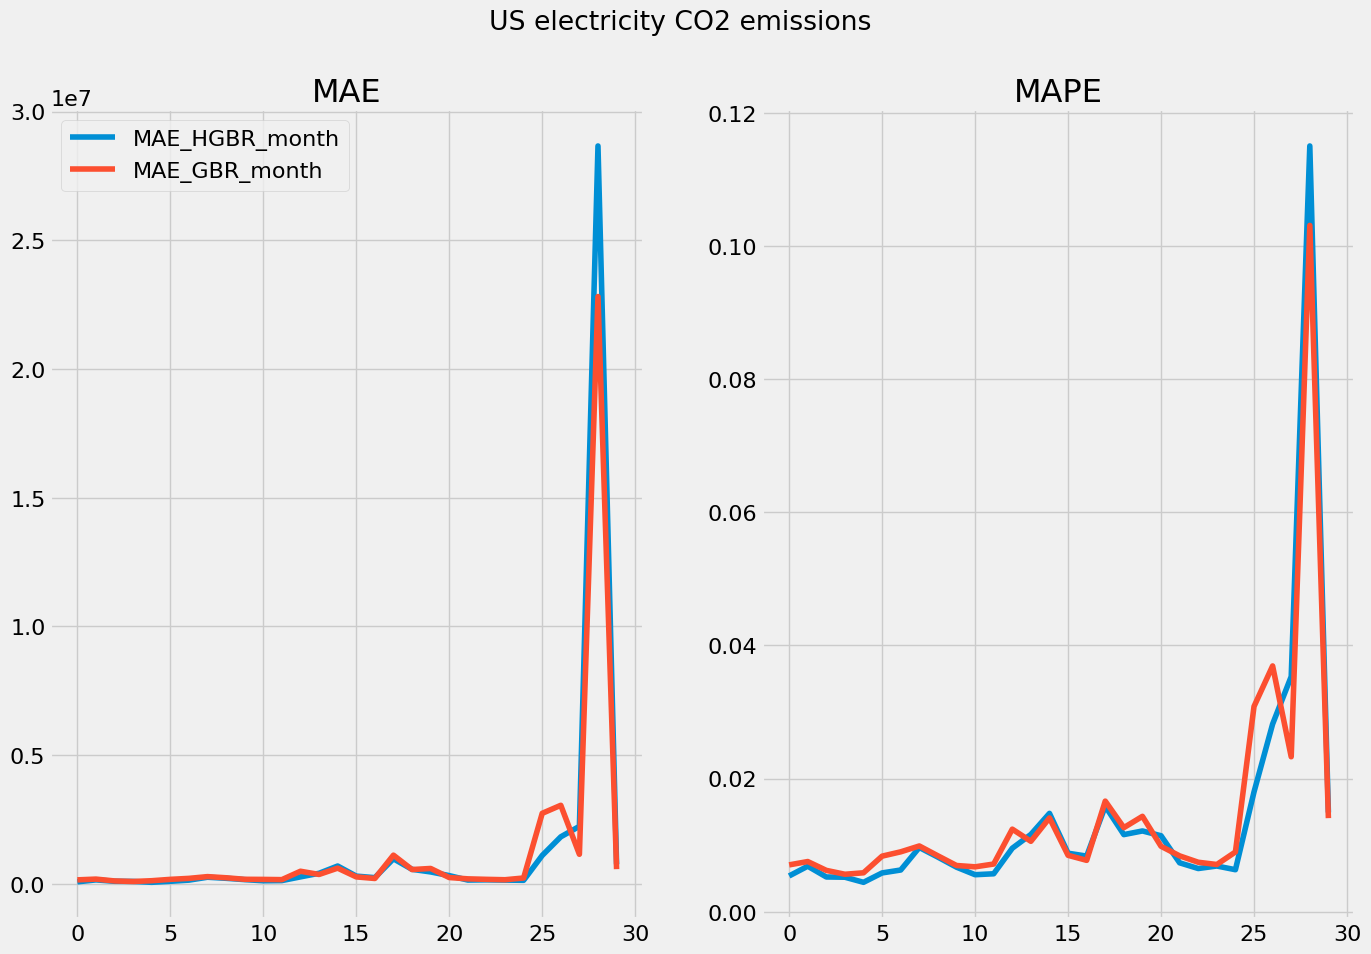

In [191]:
### Graphique de l'ensemble des Metrics ###

fig = plt.figure(figsize=(15,10))
fig = plt.gcf()

# First subplot
ax1 = fig.add_subplot(1,2,1)
ax1.plot(MAE_HGBR_month, label="MAE_HGBR_month")
#ax1.plot(MAE_LBR_month, label="MAE_LBR_month")
ax1.plot(MAE_GBR_month, label="MAE_GBR_month")
ax1.set_title('MAE')
ax1.legend()

# Second subplot
ax2 = fig.add_subplot(1,2,2)
ax2.plot(MAPE_HGBR_month, label="MAPE_HGBR_month")
#ax2.plot(MAPE_LBR_month, label="MAPE_LBR_month")
ax2.plot(MAPE_GBR_month, label="MAPE_GBR_month")
ax2.set_title('MAPE')

# Global figure methods
fig.suptitle('US electricity CO2 emissions')
plt.show()


On se rend compte que plus on se rapproche de la fin du Data Set, plus les modèles sont imprécis.
Est-ce le nombre de données qui augmente et qui influence la prédiction.

## Evolution du train sélectionné

In [193]:
X

,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,sin_month,cos_month,sin_day,cos_day,sin_hour,cos_hour,...,Temp_shift18,Temp_shift19,Temp_shift20,Temp_shift21,Temp_shift22,Temp_shift23,Temp_shift24,Type de jour TEMPO_BLANC,Type de jour TEMPO_BLEU,Type de jour TEMPO_ROUGE
48,0,0,16.9,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.000000,1.000000,...,50002.0,50251.0,51061.0,51434.0,52071.0,52745.0,52351.0,0.0,1.0,0.0
49,0,0,16.9,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.000000,1.000000,...,49041.0,50002.0,50251.0,51061.0,51434.0,52071.0,52745.0,0.0,1.0,0.0
50,0,0,16.8,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.258819,0.965926,...,48644.0,49041.0,50002.0,50251.0,51061.0,51434.0,52071.0,0.0,1.0,0.0
51,0,0,16.8,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.258819,0.965926,...,48182.0,48644.0,49041.0,50002.0,50251.0,51061.0,51434.0,0.0,1.0,0.0
52,0,0,16.8,2022,1.224647e-16,-1.000000,0.394356,0.918958,0.500000,0.866025,...,47927.0,48182.0,48644.0,49041.0,50002.0,50251.0,51061.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28601,0,0,4.8,2024,5.000000e-01,0.866025,-0.299363,-0.954139,-0.866025,0.500000,...,74286.0,74076.0,74310.0,73674.0,73785.0,73203.0,72939.0,1.0,0.0,0.0
28602,0,0,4.8,2024,5.000000e-01,0.866025,-0.299363,-0.954139,-0.707107,0.707107,...,74726.0,74286.0,74076.0,74310.0,73674.0,73785.0,73203.0,1.0,0.0,0.0
28603,0,0,4.8,2024,5.000000e-01,0.866025,-0.299363,-0.954139,-0.707107,0.707107,...,73783.0,74726.0,74286.0,74076.0,74310.0,73674.0,73785.0,1.0,0.0,0.0
28604,0,0,4.8,2024,5.000000e-01,0.866025,-0.299363,-0.954139,-0.500000,0.866025,...,71922.0,73783.0,74726.0,74286.0,74076.0,74310.0,73674.0,1.0,0.0,0.0


In [195]:
X[X['annee']>=2023]

,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,sin_month,cos_month,sin_day,cos_day,sin_hour,cos_hour,...,Temp_shift18,Temp_shift19,Temp_shift20,Temp_shift21,Temp_shift22,Temp_shift23,Temp_shift24,Type de jour TEMPO_BLANC,Type de jour TEMPO_BLEU,Type de jour TEMPO_ROUGE
10272,1,1,12.2,2023,0.5,0.866025,0.201299,0.979530,0.000000,1.000000,...,45975.0,46147.0,46158.0,46566.0,47681.0,47949.0,48297.0,0.0,1.0,0.0
10273,1,1,12.2,2023,0.5,0.866025,0.201299,0.979530,0.000000,1.000000,...,45524.0,45975.0,46147.0,46158.0,46566.0,47681.0,47949.0,0.0,1.0,0.0
10274,1,1,12.2,2023,0.5,0.866025,0.201299,0.979530,0.258819,0.965926,...,44738.0,45524.0,45975.0,46147.0,46158.0,46566.0,47681.0,0.0,1.0,0.0
10275,1,1,12.2,2023,0.5,0.866025,0.201299,0.979530,0.258819,0.965926,...,44407.0,44738.0,45524.0,45975.0,46147.0,46158.0,46566.0,0.0,1.0,0.0
10276,1,1,12.2,2023,0.5,0.866025,0.201299,0.979530,0.500000,0.866025,...,44992.0,44407.0,44738.0,45524.0,45975.0,46147.0,46158.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28601,0,0,4.8,2024,0.5,0.866025,-0.299363,-0.954139,-0.866025,0.500000,...,74286.0,74076.0,74310.0,73674.0,73785.0,73203.0,72939.0,1.0,0.0,0.0
28602,0,0,4.8,2024,0.5,0.866025,-0.299363,-0.954139,-0.707107,0.707107,...,74726.0,74286.0,74076.0,74310.0,73674.0,73785.0,73203.0,1.0,0.0,0.0
28603,0,0,4.8,2024,0.5,0.866025,-0.299363,-0.954139,-0.707107,0.707107,...,73783.0,74726.0,74286.0,74076.0,74310.0,73674.0,73785.0,1.0,0.0,0.0
28604,0,0,4.8,2024,0.5,0.866025,-0.299363,-0.954139,-0.500000,0.866025,...,71922.0,73783.0,74726.0,74286.0,74076.0,74310.0,73674.0,1.0,0.0,0.0


In [196]:
X = df_final[df_final['annee']>=2023].drop(columns='Consommation')
y = df_final[df_final['annee']>=2023][['Consommation']]

n_glob = X.shape[0]

MAE_HGBR_month = []
MAE_LBR_month = []
MAE_GBR_month = []

MAPE_HGBR_month = []
MAPE_LBR_month = []
MAPE_GBR_month = []

for k in range(15,0,-1):
    print(f"---------- Jour numéro {k} ----------")
    n_index = n_glob - 48*k

    X_train = X.iloc[:-n_index]
    X_test = X.iloc[-n_index:-n_index+48] #On effectue le test sur 30 jours

    y_train = y.iloc[:-n_index]
    y_test = y.iloc[-n_index:-n_index+48] #On effectue le test sur 30 jours

    # Step 0 - Instanciate Robust Scale
    rb_scaler = RobustScaler()
    # Step 1- Fit the scaler
    rb_scaler.fit(X_train)
    # 2-Scale/Transform
    X_train_scaled = rb_scaler.transform(X_train)
    X_test_scaled = rb_scaler.transform(X_test)

    ########Calcul#######
    #HGBR
    regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
    regressor.fit(X_train_scaled, y_train)
    y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)

    MAE_HGBR = mean_squared_error(y_test["Consommation"],y_test["predictions_HGBR"])
    MAPE_HGBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_HGBR"])

    MAE_HGBR_month.append(MAE_HGBR)
    MAPE_HGBR_month.append(MAPE_HGBR)

    #LBR
    regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 100,
                                 max_depth    = 3)

    regressor.fit(X_train_scaled, y_train)
    y_test["predictions_Linear"] = regressor.predict(X_test_scaled)

    MAE_LBR = mean_squared_error(y_test["Consommation"],y_test["predictions_Linear"])
    MAPE_LBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_Linear"])

    MAE_LBR_month.append(MAE_LBR)
    MAPE_LBR_month.append(MAPE_LBR)

    #GBR
    regressor = GradientBoostingRegressor(n_estimators=200)
    regressor.fit(X_train_scaled, y_train)

    y_test["predictions_GBR"] = regressor.predict(X_test_scaled)

    MAE_GBR = mean_squared_error(y_test["Consommation"],y_test["predictions_GBR"])
    MAPE_GBR = mean_absolute_percentage_error(y_test["Consommation"],y_test["predictions_GBR"])

    MAE_GBR_month.append(MAE_GBR)
    MAPE_GBR_month.append(MAPE_GBR)


---------- Jour numéro 15 ----------


/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

---------- Jour numéro 14 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 13 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 12 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 11 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 10 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 9 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 8 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 7 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 6 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 5 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 4 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 3 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 2 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

---------- Jour numéro 1 ----------


/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_HGBR"] = regressor.predict(X_test_scaled)
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_60769/3660191324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["predictions_Linear"] = regressor.predict(X_test_scaled)
/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversio

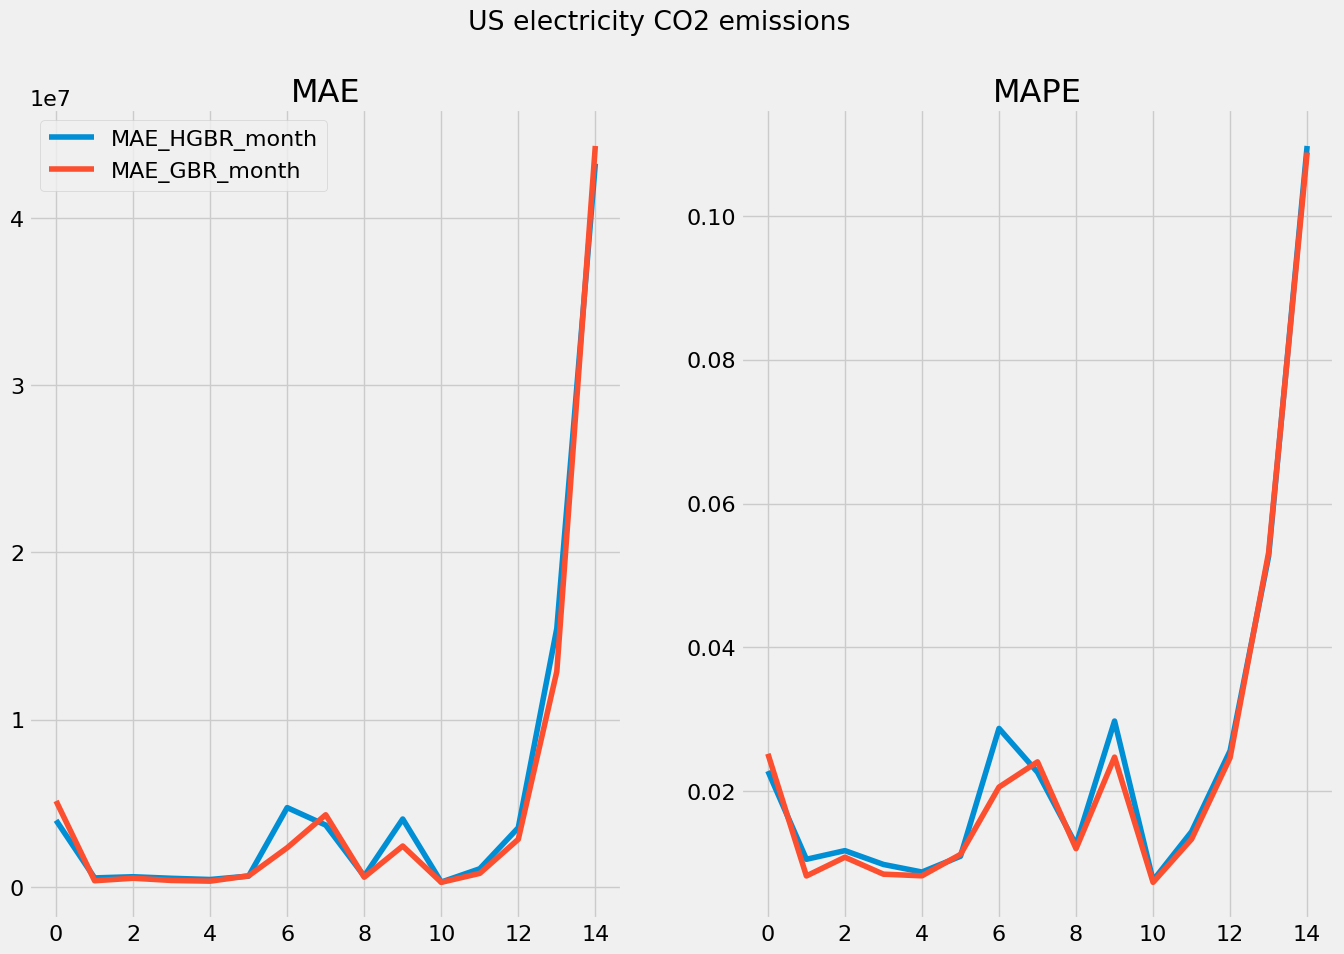

In [199]:
### Graphique de l'ensemble des Metrics ###

fig = plt.figure(figsize=(15,10))
fig = plt.gcf()

# First subplot
ax1 = fig.add_subplot(1,2,1)
ax1.plot(MAE_HGBR_month, label="MAE_HGBR_month")
#ax1.plot(MAE_LBR_month, label="MAE_LBR_month")
ax1.plot(MAE_GBR_month, label="MAE_GBR_month")
ax1.set_title('MAE')
ax1.legend()

# Second subplot
ax2 = fig.add_subplot(1,2,2)
ax2.plot(MAPE_HGBR_month, label="MAPE_HGBR_month")
#ax2.plot(MAPE_LBR_month, label="MAPE_LBR_month")
ax2.plot(MAPE_GBR_month, label="MAPE_GBR_month")
ax2.set_title('MAPE')

# Global figure methods
fig.suptitle('US electricity CO2 emissions')
plt.show()
